In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class ScaledTanh(nn.Module):
    def __init__(self, scale=4.0):
        super().__init__()
        self.scale = scale
    def forward(self, x):
        return torch.tanh(x / self.scale)

class NeuralNetwork(nn.Module):
    def __init__(self, neuronsperlayer1, neuronsperlayer2, learning_rate):
        super().__init__()
        self.device = torch.device("mps")
        
        self.noflayers1 = len(neuronsperlayer1)
        layers_encoder = []
        
        for i in range(self.noflayers1-1):
            layers_encoder.append(nn.Linear(neuronsperlayer1[i], neuronsperlayer1[i+1]))

            if i < self.noflayers1 - 2:
                layers_encoder.append(nn.LayerNorm(neuronsperlayer1[i+1]))
                layers_encoder.append(nn.LeakyReLU(0.1))  
            
        self.encoder = nn.Sequential(*layers_encoder)
        
        self.noflayers2 = len(neuronsperlayer2)
        layers_decoder = []
        
        for i in range(self.noflayers2-1):
            layers_decoder.append(nn.Linear(neuronsperlayer2[i], neuronsperlayer2[i+1]))
            
            if i < self.noflayers2 - 2:
                layers_decoder.append(nn.LayerNorm(neuronsperlayer2[i+1]))
                layers_decoder.append(nn.LeakyReLU(0.1))
            else:
                layers_decoder.append(ScaledTanh(scale=4.0)) 
            
        self.decoder = nn.Sequential(*layers_decoder)

        self.to(self.device)
        
        for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.kaiming_uniform_(m.weight, a=0.1)
                    nn.init.zeros_(m.bias)
        
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, factor=0.5, patience=100, threshold=5e-4, threshold_mode="rel", cooldown=50, min_lr=1e-4)

    def forward(self, input_layer):
        if not torch.is_tensor(input_layer):
            input_layer = torch.tensor(input_layer, dtype=torch.float32)
        if input_layer.device != self.device:
            input_layer = input_layer.to(self.device)
        return self.decoder(self.encoder(input_layer))

    def update(self, x, y):
        self.optimizer.zero_grad()
        out = self.forward(x)
        loss = self.loss_function(out, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()
                
    def learn(self, training_data, target, epochs, batch_size): #Stochastic Gradient Descent 
        X = torch.as_tensor(training_data, dtype=torch.float32, device=self.device)
        Y = torch.as_tensor(target, dtype=torch.float32, device=self.device)
        
        dataset = torch.utils.data.TensorDataset(X, Y)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        for epoch in range(1, epochs + 1):
            running_loss = 0.0
            
            for x, y in loader:
                running_loss += self.update(x, y)

            average_loss = running_loss / len(loader)
            self.scheduler.step(average_loss)

            if epoch % 500 == 0 or epoch == 1:
                learning_rate = self.scheduler.get_last_lr()[0]
                print(f"Epoch {epoch:4d}/{epochs} – Loss {average_loss:.4f} – Learning Rate {learning_rate:.1e}")


In [2]:
file_path = "/Users/davidseager/Desktop/Programming/Ising/Data/Ising Systems/"
temps = np.load("/Users/davidseager/Desktop/Programming/Ising/Data/Temperatures.npy")
sizeoflattices = 50
training_data = []
testing_data = []

for temp in temps:
    path = file_path + f"L{sizeoflattices}_T{temp:.3f}.npy"
    lattices = np.load(path)
    training_data.append(lattices[:400])
    testing_data.append(lattices[400:])
        
training_data = np.array(training_data, dtype=np.float32).reshape(-1, 50*50)
testing_data = np.array(testing_data, dtype=np.float32).reshape(-1, 50*50)    

epochs = 5000
batch_size = 256
learning_rate = 3e-4

net = NeuralNetwork([sizeoflattices**2, 2048, 1024, 512, 64, 2], [2, 64, 512, 1024, 2048, sizeoflattices**2], learning_rate=learning_rate)
net.learn(training_data=training_data, target=training_data, epochs=epochs, batch_size=batch_size)
torch.save(net.state_dict(), "autoencoder.pth")


Epoch    1/5000 – Loss 0.6505 – Learning Rate 3.0e-04
Epoch  500/5000 – Loss 0.5856 – Learning Rate 3.0e-04
Epoch 1000/5000 – Loss 0.5647 – Learning Rate 3.0e-04
Epoch 1500/5000 – Loss 0.5479 – Learning Rate 3.0e-04
Epoch 2000/5000 – Loss 0.5313 – Learning Rate 3.0e-04
Epoch 2500/5000 – Loss 0.5191 – Learning Rate 3.0e-04
Epoch 3000/5000 – Loss 0.5075 – Learning Rate 3.0e-04
Epoch 3500/5000 – Loss 0.4975 – Learning Rate 3.0e-04
Epoch 4000/5000 – Loss 0.4898 – Learning Rate 3.0e-04
Epoch 4500/5000 – Loss 0.4735 – Learning Rate 1.0e-04
Epoch 5000/5000 – Loss 0.4698 – Learning Rate 1.0e-04


In [11]:
device = "mps"

X_test = torch.as_tensor(testing_data, dtype=torch.float32, device=device)

with torch.no_grad():
    out = net(X_test)
    predictions = torch.where(out >= 0, 1.0, -1.0)
    accuracy = (predictions == X_test).float().mean().item() * 100

print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 71.18%


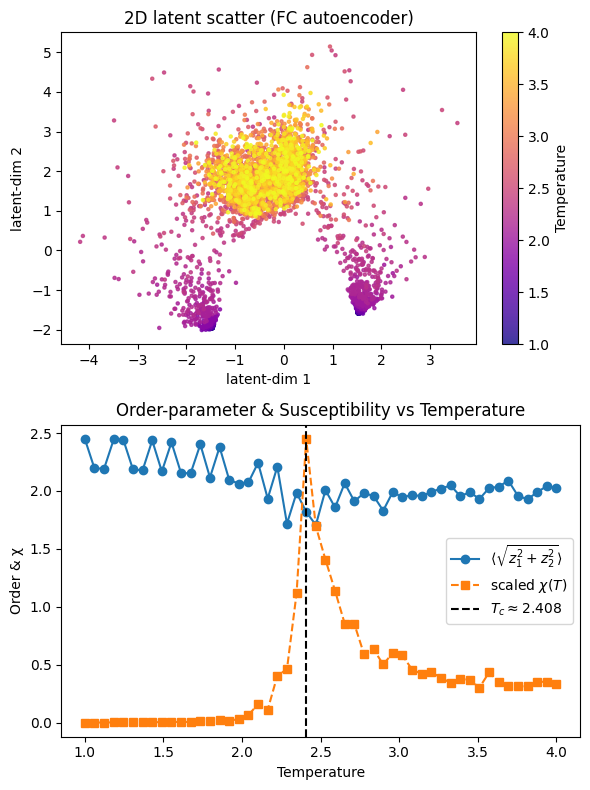

In [26]:
import matplotlib.pyplot as plt

X = torch.tensor(testing_data, dtype=torch.float32, device=device)

with torch.no_grad():
    X_flat = X.view(X.size(0), -1)    
    Z_all = net.encoder(X).cpu().numpy()

M = len(temps)
N = testing_data.shape[0] // M
T_labels = np.repeat(temps, N)

unique_temps = np.unique(T_labels)

z = np.sqrt(Z_all[:, 0]**2 + Z_all[:, 1]**2)
order = np.array([np.median(np.abs(z[T_labels == T])) for T in unique_temps])
chi = np.array([(np.var(z[T_labels == T]) * (sizeoflattices**2)) / T for T in unique_temps])

Tc_index = np.argmax(chi)
Tc = unique_temps[Tc_index]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

sc = ax1.scatter(Z_all[:,0], Z_all[:,1], c=T_labels, s=5, cmap="plasma", alpha=0.8)
ax1.set_title("2D latent scatter (FC autoencoder)")
ax1.set_xlabel("latent-dim 1")
ax1.set_ylabel("latent-dim 2")
plt.colorbar(sc, ax=ax1, label="Temperature")

ax2.plot(unique_temps, order, 'o-', label=r"$\langle \sqrt{z_1^2+z_2^2}\rangle$")
ax2.plot(unique_temps,chi/chi.max()*order.max(),'s--', label=r"scaled $\chi(T)$")
ax2.axvline(Tc, color='k', linestyle='--',label=f"$T_c\\approx{Tc:.3f}$")
ax2.set_xlabel("Temperature")
ax2.set_ylabel("Order & χ")
ax2.set_title("Order-parameter & Susceptibility vs Temperature")
ax2.legend()

plt.tight_layout()
plt.show()
